#**ML problem - producing most accurate regressor on abstract data**

**Pre experiment phase:**
- 1) Preliminary analysis
  - 1.1) print data
  - 1.2) Visualization
  - 1.3) Indicating presence of NaN values in dataset
  - 1.4) Range of (continous) target values
  - 1.5) Number of samples and features
  - 1.6) Final conclusions of preliminary analysis for Preprocessing

**Experiment phase:**
- 2) Preprocessing
  - 2.1) MEAN value for NaN-value samples
  - 2.2) Standard scaling

- 3) Metrics selection

- 4) Model training and evaluation
  - 4.1) Selections
  - 4.2) Training
  - 4.3) Evaluation on dev-set

- 5) Best model selection

- 6) Optuna hyperparameter optimization
  - 6.1) Hyperparameter tuning
  - 6.2) Visualization of hyperparameter tuning
  - 6.3) Print best paramaters
  - 6.4) Improvement on MSE
  
**Post experiment phase:**
- 7) Final evaluation on test set

###**1) Preliminary data analysis:**



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

####**1.1) Print data**

In [2]:
raw_data = pd.read_pickle('/content/ass3.pickle')
print(raw_data)

{'train':            f0    f1        f2        f3      f4        f5     f6      f7  \
14981  4.0391  15.0  6.297710  0.992366   334.0  2.549618  32.72 -116.99   
6614   4.7241  46.0  5.375758  0.954545   753.0  2.281818  34.17 -118.10   
14233  3.3553   7.0  5.229213  1.101124  1304.0  2.930337  32.70 -117.01   
1802   1.3929  52.0  5.000000  0.953488   126.0  2.930233  37.92 -122.36   
6030   1.6006  52.0  4.427083  1.017361  1246.0  2.163194  34.07 -117.75   
...       ...   ...       ...       ...     ...       ...    ...     ...   
4653   8.3617  52.0  5.516129       NaN   737.0  2.971774  34.06 -118.33   
7250   2.5395  26.0  4.528600  1.053254  1777.0  3.504931  33.99 -118.12   
17934  3.6118  48.0  4.387324  1.035211   697.0  2.454225  37.35 -121.95   
1355   3.5436  16.0  5.013825  1.069124  1410.0  3.248848  38.03 -121.92   
11666  3.8864  29.0  5.160000  1.117500  1265.0  3.162500  33.85 -118.01   

       target  
14981   1.695  
6614    2.796  
14233   1.322  
1802    1.042

In [3]:
# train set
X_train = raw_data['train'].iloc[:,0:8] # all features
y_train = raw_data['train']['target'] # target

# dev set
X_dev = raw_data['dev'].iloc[:,0:8]
y_dev = raw_data['dev']['target']

# test set
X_test = raw_data['test'].iloc[:,0:8]
y_test = raw_data['test']['target']

####**1.2) Visualization**

***Visualization of train-set for first impressions***

**Distribution of targets to samples**

In [186]:
def plot_target_distribution(target):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

    # Plot histogram
    axes[0].hist(y_train, bins=20, alpha=0.5)
    axes[0].set_xlabel('Target Variable')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Histogram of Target Variables')

    # Plot density plot
    sns.kdeplot(y_train, shade=True, ax=axes[1], fill=True)
    axes[1].set_xlabel('Target Variable')
    axes[1].set_ylabel('Density')

    plt.tight_layout()
    plt.show()

<ipython-input-186-3d4402a3c450>:11: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




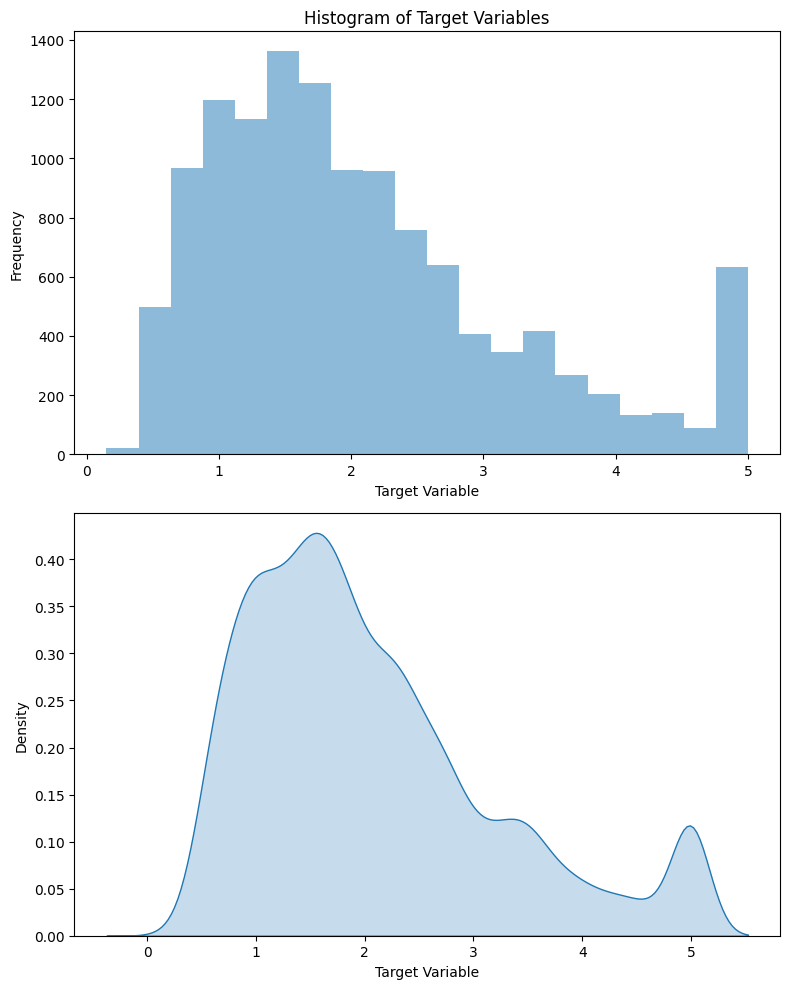

In [187]:
plot_target_distribution(y_train)

Analysis of targets distribution:
>- shows clearly that train-set is imbalanced
- most samples refers to target values in ranges of (1,2)
- least samples refers to target values around (0,1) and (3,5)








####**1.3) Range of target values**

**Distribution of each feature to targets**

In [7]:
import matplotlib.pyplot as plt
def plot_feature_vs_target(data, target):
    num_features = data.shape[1]
    fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, 6*num_features))

    for i, feature in enumerate(data.columns):
        ax = axes[i]
        ax.scatter(data[feature], target, alpha=0.3)
        ax.set_xlabel(feature)
        ax.set_ylabel('Target Variable')

    plt.tight_layout()
    plt.show()

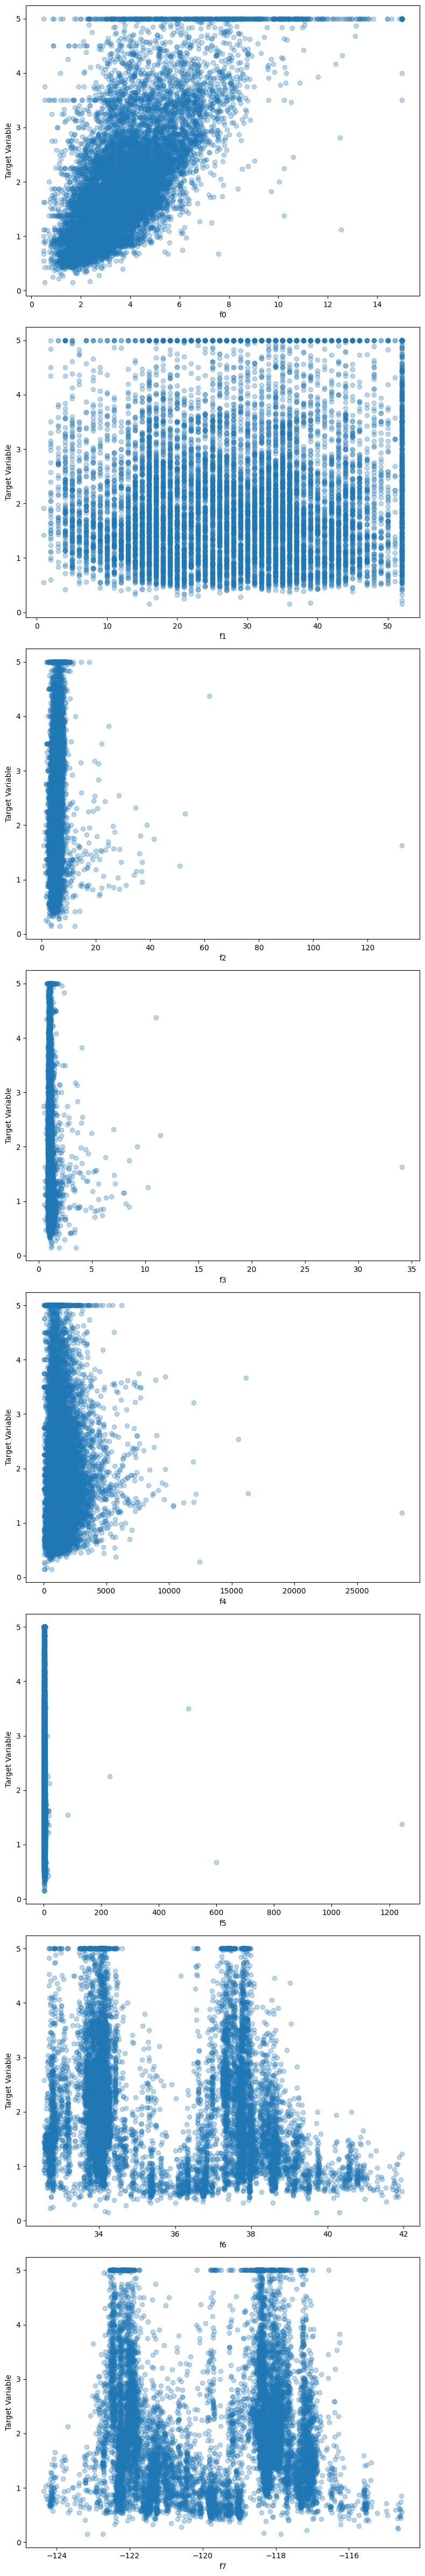

In [8]:
plot_feature_vs_target(X_train, y_train)

Analysis of features to targets distribution:


> feature 0:
- most samples are distributed around target values (0.5,2.5)

> feature 1:
- is distributed around all target values (0,6) but with higher density of samples at target values (0.5,3) and (5,6)

> feature 2:
- most samples are distributed around target values (0.5,5)

> feature 3:
- like feature 2 most samples are distributed around target values (0.5,5)

> feature 4:
- most samples are distributed around target values (0.5,3.75)

> feature 5:
- like features 2 and 3 most samples are distributed around target values (0.5,5)

> feature 6:
- most samples are distributed around target values (0.5,1)

> feature 7:
- most samples are distributed around target values (0.5,1.5)

####**1.4) Indicating presence of NaN values in dataset**

In [9]:
def check_nan_values(dataset):
    nan_indices = np.isnan(dataset).any(axis=1)
    if np.any(nan_indices):
        print("There are samples with NaN values.")
    else:
        print("No samples with NaN values found.")

In [10]:
print("Check NaN values in train-set:")
check_nan_values(X_train)
print("\nCheck NaN values in dev-set:")
check_nan_values(X_dev)
print("\nCheck NaN values in test-set:")
check_nan_values(X_test)


Check NaN values in train-set:
There are samples with NaN values.

Check NaN values in dev-set:
No samples with NaN values found.

Check NaN values in test-set:
No samples with NaN values found.


In [11]:
def plot_nan_values(dataset):
    plt.figure(figsize=(10, 6))
    sns.heatmap(np.isnan(dataset), cmap='binary')
    plt.title('Presence of NaN Values')
    plt.xlabel('Features')
    plt.ylabel('Samples')
    plt.show()

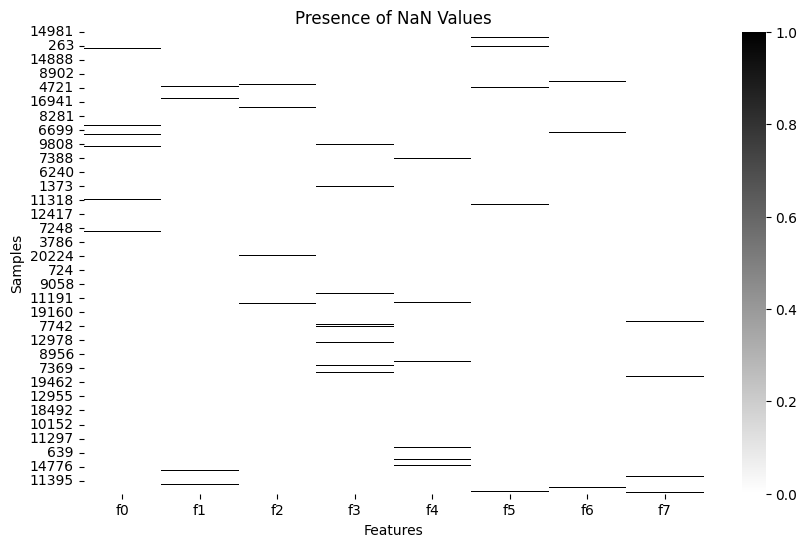

In [12]:
plot_nan_values(X_train)

####**1.5) Number of samples and features**

Now get the exact numbers of distribution:

In [13]:
# print train set
print('Total number of (samples, features) in train-set is:', X_train.shape)
print('Number of samples of each lable is:')
print(y_train.value_counts(), '\n')

# print dev set
print('Total number of (samples, features) in dev-set is:', X_dev.shape)
print('Number of samples of each lable is:')
print(y_dev.value_counts(), '\n')

# print test set
print('Total number of (samples, features) in test-set is:', X_test.shape)
print(y_test.value_counts(), '\n')

Total number of (samples, features) in train-set is: (12384, 8)
Number of samples of each lable is:
5.00001    558
1.37500     81
1.62500     62
1.12500     60
1.87500     58
          ... 
2.05500      1
2.94500      1
3.39400      1
0.59700      1
2.35500      1
Name: target, Length: 3391, dtype: int64 

Total number of (samples, features) in dev-set is: (4128, 8)
Number of samples of each lable is:
5.00001    198
1.62500     31
2.25000     25
1.75000     18
0.67500     18
          ... 
2.16100      1
2.78200      1
1.83600      1
0.14999      1
2.73500      1
Name: target, Length: 2162, dtype: int64 

Total number of (samples, features) in test-set is: (4128, 8)
5.00001    209
1.12500     28
1.62500     24
1.37500     23
0.87500     19
          ... 
2.27800      1
0.91800      1
1.37200      1
3.63800      1
2.79500      1
Name: target, Length: 2160, dtype: int64 



####**1.6) Final conclusions of preliminary analysis for Preprocessing**

> - for samples with NaN-values standardize by MEAN value in order to not loosing data
- balance train-set for regressor which are sensitive to imbalanced data




###**2) Preprocessing**



In [14]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

*Explanation:*
> To not loose may important data, we input mean value in NaN samples instead of removing those samples.

> Standard scaling specifically for Support Vector Regressor and generally for faster training and evaluation.





####**2.1) Replacing NaN samples with Mean**

In [15]:
# Step 2.1: Handle samples with NaN values in the train set
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

####**2.2) Standard scaling**

In [41]:
# Step 2.2: Standardize data set
scaler = StandardScaler()
# Standardize the train set
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_dev_scaled = scaler.transform(X_dev)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


###**3) Metrics selection**






We'll evaluate due to following metrices:
- MSE (Mean squared error)
- MAE (Mean absolute error)
- R2-score

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

###**4) Model training and evaluation**




We'll train the following models:

- Linear Regressor
- Decision Tree Regressor
- Random Forest Regressor
- Gradient Boosting Regressor
- XGB Regressor
- Support Vector Regressor

Hence the dataset is provided with labels/targets we won't train clustering models.

In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

####**4.1) Model selections**

In [73]:
# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'Gradient Boosting Regression': GradientBoostingRegressor(),
    'XGB Regressor': XGBRegressor(),
    'Support Vector Regression': SVR()
}
# Dictionary to store cross-validation results
cv_results = {}

####**4.2) Training**

In [74]:
# Perform cross-validation for each model
for model_name, model in models.items():
    # Perform cross-validation with neg_MSE scoring
    neg_mse_scores = -cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

    # Perform cross-validation with R2 scoring
    r2_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')

    # Perform cross-validation with neg_MAE scoring
    mae_score = -cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')

    # Save the cross-validation results
    cv_results[model_name] = {'MSE': neg_mse_scores, 'R2': r2_scores}

    # Print the cross-validation results
    print(f"Model: {model_name}")
    print(f"Cross-Validation MSE scores: {neg_mse_scores}")
    print(f"Average MSE: {neg_mse_scores.mean()}")
    print(f"Cross-Validation R2 scores: {r2_scores}")
    print(f"Average R2: {r2_scores.mean()}")
    print(f"Cross-Validation MAE scores: {mae_score}")
    print(f"Average MAE scores: {mae_score.mean()} \n")

Model: Linear Regression
Cross-Validation MSE scores: [0.54551951 0.5354599  0.60182515 0.54816265 0.53581956]
Average MSE: 0.5533573566623324
Cross-Validation R2 scores: [0.58649008 0.59299051 0.53216837 0.59220913 0.59472085]
Average R2: 0.5797157883272115
Cross-Validation MAE scores: [0.54888834 0.538213   0.54981779 0.5419801  0.54206887]
Average MAE scores: 0.5441936203890856 

Model: Decision Tree Regression
Cross-Validation MSE scores: [0.56752292 0.58764572 0.62721258 0.5880298  0.5822495 ]
Average MSE: 0.5905321040731397
Cross-Validation R2 scores: [0.57984055 0.55418627 0.51832801 0.55576883 0.54966894]
Average R2: 0.5515585184649797
Cross-Validation MAE scores: [0.46956595 0.50013727 0.51494592 0.50160356 0.49247462]
Average MAE scores: 0.4957454642409685 

Model: Random Forest Regression
Cross-Validation MSE scores: [0.27807942 0.29031384 0.30612487 0.296206   0.27341443]
Average MSE: 0.28882771288311304
Cross-Validation R2 scores: [0.78926308 0.78222833 0.76474655 0.775201

####**4.2) Evaluation of models on dev-set**

In [75]:
dev_results = []

# Perform evaluation on the dev set for each model
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)  # Fit the model on the entire training set

    # Make predictions on the scaled dev set
    y_pred_dev = model.predict(X_dev_scaled)

    # Calculate MSE, MAE and R2 score on the dev set
    mse_dev = mean_squared_error(y_dev, y_pred_dev)
    mae_dev = mean_absolute_error(y_dev, y_pred_dev)
    r2_dev = r2_score(y_dev, y_pred_dev)

    # Save the evaluation results on the dev set
    dev_results.append({'Model': model, 'MSE': mse_dev,'MAE':mae_dev ,'R2': r2_dev})
    # Print the evaluation results on the dev set
    print(f"Model: {model_name}")
    print(f"Dev Set MSE: {mse_dev}")
    print(f"Dev Set MAE: {mae_dev}")
    print(f"Dev Set R2 Score: {r2_dev} \n")

Model: Linear Regression
Dev Set MSE: 0.522904334901607
Dev Set MAE: 0.5231571750489642
Dev Set R2 Score: 0.6008414936534726 

Model: Decision Tree Regression
Dev Set MSE: 0.5924262484003633
Dev Set MAE: 0.4966147456395349
Dev Set R2 Score: 0.5477720098142582 

Model: Random Forest Regression
Dev Set MSE: 0.27131013232068646
Dev Set MAE: 0.34295921354166686
Dev Set R2 Score: 0.7928956791031738 

Model: Gradient Boosting Regression
Dev Set MSE: 0.29572496858654373
Dev Set MAE: 0.3735670767441321
Dev Set R2 Score: 0.7742586380115019 

Model: XGB Regressor
Dev Set MSE: 0.23221194330511932
Dev Set MAE: 0.32462535615801813
Dev Set R2 Score: 0.8227412429791064 

Model: Support Vector Regression
Dev Set MSE: 0.3718693531845113
Dev Set MAE: 0.4042797353534498
Dev Set R2 Score: 0.7161338974152716 



##**5) Best model selection**

In [150]:
# Sort models based on MSE on the dev set in ascending order
sorted_models_dev = sorted(dev_results, key=lambda x: x['MSE'])

# Select the best model based on MSE on the dev set
best_model = sorted_models_dev[:1]
best_model = best_model[0]['Model']

In [170]:
print(f'Best model on dev-set is \n')
print(f"Model: {best_model}")
print(f"MSE: {model['MSE']}")
print(f"MAE: {model['MAE']}")
print(f"R2 Score: {model['R2']} \n")


Best model on dev-set is 

Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gb_learning_rate=0.05642883289545494, gb_max_depth=8,
             gb_min_samples_leaf=7, gb_n_estimators=500, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09210504302576741,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_features='log2',
             max_leaves=None, min_child_weight=None, min_samples_leaf=1,
             min_samples_split=7, ...)
MSE: 0.23221194330511932
MAE: 0.32462535615801813
R2 Score: 0.8227412429791064 



*Explanation:*


> As expexted, the Extreme Gradient Boost Regressor performed best on dev-set.
We'll now tune it's hyperparamters and refit it on train-set in order to check whether an improvement on MSE performance can be achieved.



##**6) Optuna hyperparameter optimization**





In [ ]:
!pip install optuna
import optuna

####**6.1) Hyperparameter tuning**





In [162]:
best_params = None
best_mse = 0.0

In [165]:
def objective(trial):
    global best_model
    global best_params
    global best_mse

    # Define the hyperparameter search spaces for the second model (Gradient Boosting)
    XGBR_params = {
    'n_estimators': trial.suggest_float('gb_n_estimators', 100, 500, step=100, log=True),
    'learning_rate': trial.suggest_loguniform('gb_learning_rate', 0.001, 0.1),
    'max_depth': trial.suggest_int('gb_max_depth', 3, 10),
    'min_samples_leaf': trial.suggest_int('gb_min_samples_leaf', 1, 10),
}

    best_model.set_params(**XGBR_params)


    # Refit on train set
    best_model.fit(X_train_scaled, y_train)

    # Evaluate models ondev-set
    y_dev_pred_best_model = best_model.predict(X_dev_scaled)
    best_model_mse_dev = mean_squared_error(y_dev, y_dev_pred_best_model)


    # Update the best model and parameters if necessary
    if best_model_mse_dev < best_mse:
        best_params = XGBR_params
        best_mse = best_model_mse_dev

    # Return the minimum MSE of the two models
    return best_mse

In [166]:
# Create the Optuna study
study = optuna.create_study(direction='minimize')

# Start the hyperparameter optimization
study.optimize(objective, n_trials=100)

[I 2023-06-24 11:24:54,780] A new study created in memory with name: no-name-548ead35-59a6-4485-9506-251b53608a70
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:24:54] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:24:59,354] Trial 0 finished with value: 0.2465687743476474 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.04507026677234494, 'gb_max_depth': 4, 'gb_min_samples_leaf': 8}. Best is trial 0 with value: 0.2465687743476474.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:24:59] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:25:05,702] Trial 1 finished with value: 0.2465687743476474 and parameters: {'gb_n_estimators': 300, 'gb_learning_rate': 0.010911642901255875, 'gb_max_depth': 9, 'gb_min_samples_leaf': 7}. Best is trial 0 with value: 0.2465687743476474.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:25:05] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:25:19,254] Trial 2 finished with value: 0.2465687743476474 and parameters: {'gb_n_estimators': 500, 'gb_learning_rate': 0.002058841297114132, 'gb_max_depth': 10, 'gb_min_samples_leaf': 5}. Best is trial 0 with value: 0.2465687743476474.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:25:19] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:25:27,816] Trial 3 finished with value: 0.24445376296182658 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.0115368789805344, 'gb_max_depth': 8, 'gb_min_samples_leaf': 4}. Best is trial 3 with value: 0.24445376296182658.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:25:27] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:25:28,395] Trial 4 finished with value: 0.24445376296182658 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.0012726203099324518, 'gb_max_depth': 3, 'gb_min_samples_leaf': 4}. Best is trial 3 with value: 0.24445376296182658.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:25:28] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:25:33,686] Trial 5 finished with value: 0.24445376296182658 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.0032146758400803215, 'gb_max_depth': 4, 'gb_min_samples_leaf': 9}. Best is trial 3 with value: 0.24445376296182658.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:25:33] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:25:38,634] Trial 6 finished with value: 0.24445376296182658 and parameters: {'gb_n_estimators': 500, 'gb_learning_rate': 0.014608259452467692, 'gb_max_depth': 5, 'gb_min_samples_leaf': 2}. Best is trial 3 with value: 0.24445376296182658.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:25:38] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:25:40,981] Trial 7 finished with value: 0.23618682734444774 and parameters: {'gb_n_estimators': 300, 'gb_learning_rate': 0.07878255649749112, 'gb_max_depth': 4, 'gb_min_samples_leaf': 3}. Best is trial 7 with value: 0.23618682734444774.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:25:40] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:25:48,664] Trial 8 finished with value: 0.23618682734444774 and parameters: {'gb_n_estimators': 500, 'gb_learning_rate': 0.006247904646707799, 'gb_max_depth': 6, 'gb_min_samples_leaf': 6}. Best is trial 7 with value: 0.23618682734444774.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:25:48] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:25:55,019] Trial 9 finished with value: 0.23618682734444774 and parameters: {'gb_n_estimators': 300, 'gb_learning_rate': 0.007020433284948066, 'gb_max_depth': 9, 'gb_min_samples_leaf': 10}. Best is trial 7 with value: 0.23618682734444774.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:25:55] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:25:58,056] Trial 10 finished with value: 0.23618682734444774 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.06759040793788146, 'gb_max_depth': 7, 'gb_min_samples_leaf': 2}. Best is trial 7 with value: 0.23618682734444774.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:25:58] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:00,523] Trial 11 finished with value: 0.22691876257832824 and parameters: {'gb_n_estimators': 200, 'gb_learning_rate': 0.09365319947310605, 'gb_max_depth': 6, 'gb_min_samples_leaf': 6}. Best is trial 11 with value: 0.22691876257832824.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:00] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:03,033] Trial 12 finished with value: 0.22333281015227477 and parameters: {'gb_n_estimators': 200, 'gb_learning_rate': 0.09554598843758151, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 12 with value: 0.22333281015227477.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:03] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:05,583] Trial 13 finished with value: 0.22333281015227477 and parameters: {'gb_n_estimators': 200, 'gb_learning_rate': 0.034724477979592376, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 12 with value: 0.22333281015227477.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:05] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:10,144] Trial 14 finished with value: 0.22333281015227477 and parameters: {'gb_n_estimators': 200, 'gb_learning_rate': 0.0331175166741085, 'gb_max_depth': 7, 'gb_min_samples_leaf': 1}. Best is trial 12 with value: 0.22333281015227477.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:10] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:12,194] Trial 15 finished with value: 0.22333281015227477 and parameters: {'gb_n_estimators': 200, 'gb_learning_rate': 0.027720091932684387, 'gb_max_depth': 5, 'gb_min_samples_leaf': 1}. Best is trial 12 with value: 0.22333281015227477.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:12] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:15,703] Trial 16 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 200, 'gb_learning_rate': 0.09986214324366104, 'gb_max_depth': 8, 'gb_min_samples_leaf': 3}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:15] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:17,554] Trial 17 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.05663645968841675, 'gb_max_depth': 8, 'gb_min_samples_leaf': 3}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:17] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:20,833] Trial 18 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.05236895183345463, 'gb_max_depth': 8, 'gb_min_samples_leaf': 4}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:20] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:23,306] Trial 19 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.02225082767116249, 'gb_max_depth': 10, 'gb_min_samples_leaf': 3}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:23] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:25,135] Trial 20 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.042916819229408605, 'gb_max_depth': 8, 'gb_min_samples_leaf': 5}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:25] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:27,001] Trial 21 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.056338412648201844, 'gb_max_depth': 8, 'gb_min_samples_leaf': 4}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:27] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:29,136] Trial 22 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.06246386495559775, 'gb_max_depth': 9, 'gb_min_samples_leaf': 3}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:29] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:34,059] Trial 23 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 200, 'gb_learning_rate': 0.054161981481607564, 'gb_max_depth': 8, 'gb_min_samples_leaf': 3}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:34] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:35,595] Trial 24 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.09026616865524778, 'gb_max_depth': 7, 'gb_min_samples_leaf': 2}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:35] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:39,813] Trial 25 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 200, 'gb_learning_rate': 0.021700526374988566, 'gb_max_depth': 9, 'gb_min_samples_leaf': 4}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:39] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:41,675] Trial 26 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.04440314831054778, 'gb_max_depth': 8, 'gb_min_samples_leaf': 5}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:41] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:46,090] Trial 27 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 200, 'gb_learning_rate': 0.06805196379906754, 'gb_max_depth': 7, 'gb_min_samples_leaf': 3}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:46] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:48,202] Trial 28 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.09743325896763956, 'gb_max_depth': 9, 'gb_min_samples_leaf': 2}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:48] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:26:56,536] Trial 29 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 300, 'gb_learning_rate': 0.04855894673359179, 'gb_max_depth': 10, 'gb_min_samples_leaf': 8}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:26:56] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:27:00,110] Trial 30 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 200, 'gb_learning_rate': 0.038719966591054554, 'gb_max_depth': 8, 'gb_min_samples_leaf': 7}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:27:00] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:27:02,633] Trial 31 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.02276605766291036, 'gb_max_depth': 10, 'gb_min_samples_leaf': 3}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:27:02] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:27:04,767] Trial 32 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.059192045315048125, 'gb_max_depth': 9, 'gb_min_samples_leaf': 4}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:27:04] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:27:08,713] Trial 33 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.028870829371492032, 'gb_max_depth': 10, 'gb_min_samples_leaf': 5}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:27:08] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:27:15,489] Trial 34 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 300, 'gb_learning_rate': 0.07208131846035559, 'gb_max_depth': 10, 'gb_min_samples_leaf': 3}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:27:15] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:27:19,055] Trial 35 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.020026325281881925, 'gb_max_depth': 9, 'gb_min_samples_leaf': 4}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:27:19] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:27:20,927] Trial 36 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.049407104183994945, 'gb_max_depth': 8, 'gb_min_samples_leaf': 2}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:27:20] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:27:24,014] Trial 37 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 200, 'gb_learning_rate': 0.03819303827376981, 'gb_max_depth': 7, 'gb_min_samples_leaf': 4}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:27:24] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:27:25,069] Trial 38 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.0773546863382299, 'gb_max_depth': 5, 'gb_min_samples_leaf': 2}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:27:25] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:27:31,951] Trial 39 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 300, 'gb_learning_rate': 0.014939241091815566, 'gb_max_depth': 8, 'gb_min_samples_leaf': 6}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:27:31] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:27:33,173] Trial 40 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 200, 'gb_learning_rate': 0.0466727586106629, 'gb_max_depth': 3, 'gb_min_samples_leaf': 5}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:27:33] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:27:35,022] Trial 41 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.04479409816706866, 'gb_max_depth': 8, 'gb_min_samples_leaf': 5}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:27:35] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:27:37,163] Trial 42 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.06039835999480741, 'gb_max_depth': 9, 'gb_min_samples_leaf': 4}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:27:37] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:27:38,731] Trial 43 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.02927351151184783, 'gb_max_depth': 7, 'gb_min_samples_leaf': 3}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:27:38] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:27:41,992] Trial 44 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.0775446466572447, 'gb_max_depth': 8, 'gb_min_samples_leaf': 7}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:27:42] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:27:44,490] Trial 45 finished with value: 0.22032478938666594 and parameters: {'gb_n_estimators': 100, 'gb_learning_rate': 0.03794240246194951, 'gb_max_depth': 10, 'gb_min_samples_leaf': 5}. Best is trial 16 with value: 0.22032478938666594.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:27:44] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:27:50,336] Trial 46 finished with value: 0.21870200921098268 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.07537608603161194, 'gb_max_depth': 7, 'gb_min_samples_leaf': 3}. Best is trial 46 with value: 0.21870200921098268.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:27:50] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:27:57,634] Trial 47 finished with value: 0.21740773570111657 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.078910655455104, 'gb_max_depth': 7, 'gb_min_samples_leaf': 3}. Best is trial 47 with value: 0.21740773570111657.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:27:57] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:28:03,503] Trial 48 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.08465101276531638, 'gb_max_depth': 7, 'gb_min_samples_leaf': 2}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:28:03] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:28:09,723] Trial 49 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.09997897410996319, 'gb_max_depth': 6, 'gb_min_samples_leaf': 2}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:28:09] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:28:14,577] Trial 50 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.08795792515232571, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:28:14] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:28:20,896] Trial 51 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.08368672151401421, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:28:20] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:28:25,798] Trial 52 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.08186517363238076, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:28:25] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:28:32,169] Trial 53 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.08423745077268854, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:28:32] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:28:37,137] Trial 54 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.08589886677474412, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:28:37] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:28:43,462] Trial 55 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 500, 'gb_learning_rate': 0.09928701913477589, 'gb_max_depth': 5, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:28:43] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:28:49,563] Trial 56 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 500, 'gb_learning_rate': 0.06552091939604547, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:28:49] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:28:54,960] Trial 57 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.08473707405343708, 'gb_max_depth': 5, 'gb_min_samples_leaf': 2}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:28:54] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:28:59,940] Trial 58 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.0669176258619541, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:28:59] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:29:06,311] Trial 59 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.0997347331887526, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:29:06] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:29:10,179] Trial 60 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 500, 'gb_learning_rate': 0.07884194075772105, 'gb_max_depth': 4, 'gb_min_samples_leaf': 2}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:29:10] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:29:16,534] Trial 61 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.08554650042473115, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:29:16] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:29:21,428] Trial 62 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.08637426222662982, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:29:21] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:29:26,830] Trial 63 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.06619312474118476, 'gb_max_depth': 5, 'gb_min_samples_leaf': 2}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:29:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:29:31,772] Trial 64 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.05406252804138326, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:29:31] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:29:35,517] Trial 65 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 300, 'gb_learning_rate': 0.08630563654988259, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:29:35] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:29:40,962] Trial 66 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.06919976178794998, 'gb_max_depth': 5, 'gb_min_samples_leaf': 2}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:29:40] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:29:47,069] Trial 67 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 500, 'gb_learning_rate': 0.058431026843893924, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:29:47] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:29:54,294] Trial 68 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.09069155281938229, 'gb_max_depth': 7, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:29:54] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:29:58,303] Trial 69 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.07159191037132359, 'gb_max_depth': 5, 'gb_min_samples_leaf': 2}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:29:58] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:30:03,610] Trial 70 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 300, 'gb_learning_rate': 0.05269905546488726, 'gb_max_depth': 6, 'gb_min_samples_leaf': 2}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:30:03] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:30:07,452] Trial 71 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 500, 'gb_learning_rate': 0.09496439963567901, 'gb_max_depth': 4, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:30:07] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:30:13,797] Trial 72 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 500, 'gb_learning_rate': 0.09721297635064723, 'gb_max_depth': 5, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:30:13] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:30:17,755] Trial 73 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.09986085302141826, 'gb_max_depth': 5, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:30:17] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:30:22,647] Trial 74 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.06169096797949873, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:30:22] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:30:31,291] Trial 75 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 500, 'gb_learning_rate': 0.0820288110480635, 'gb_max_depth': 7, 'gb_min_samples_leaf': 10}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:30:31] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:30:37,529] Trial 76 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.07125076443298242, 'gb_max_depth': 6, 'gb_min_samples_leaf': 2}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:30:37] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:30:44,587] Trial 77 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 500, 'gb_learning_rate': 0.08776133384546744, 'gb_max_depth': 7, 'gb_min_samples_leaf': 2}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:30:44] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:30:48,864] Trial 78 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 300, 'gb_learning_rate': 0.0621468690412616, 'gb_max_depth': 5, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:30:48] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:30:53,669] Trial 79 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.07374344024589956, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:30:53] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:30:59,971] Trial 80 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.050889302360809484, 'gb_max_depth': 6, 'gb_min_samples_leaf': 2}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:31:00] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:31:06,013] Trial 81 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 500, 'gb_learning_rate': 0.06383848764686403, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:31:06] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:31:13,478] Trial 82 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 500, 'gb_learning_rate': 0.07986989393382923, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:31:13] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:31:20,591] Trial 83 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 500, 'gb_learning_rate': 0.08909422162049659, 'gb_max_depth': 7, 'gb_min_samples_leaf': 2}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:31:20] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:31:26,910] Trial 84 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.09963403651355587, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:31:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:31:31,777] Trial 85 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.06867162207326584, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:31:31] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:31:38,086] Trial 86 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 500, 'gb_learning_rate': 0.05707346902374883, 'gb_max_depth': 5, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:31:38] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:31:43,871] Trial 87 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.0773212884809936, 'gb_max_depth': 7, 'gb_min_samples_leaf': 2}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:31:43] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:31:48,225] Trial 88 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 300, 'gb_learning_rate': 0.08643580591577374, 'gb_max_depth': 5, 'gb_min_samples_leaf': 8}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:31:48] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:31:51,276] Trial 89 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.04613076146273893, 'gb_max_depth': 4, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:31:51] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:31:58,427] Trial 90 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.0645036464260447, 'gb_max_depth': 7, 'gb_min_samples_leaf': 2}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:31:58] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:32:02,345] Trial 91 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.08160564701418715, 'gb_max_depth': 5, 'gb_min_samples_leaf': 2}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:32:02] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:32:07,263] Trial 92 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.07111893168683113, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:32:07] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:32:13,425] Trial 93 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.0896503142196848, 'gb_max_depth': 6, 'gb_min_samples_leaf': 2}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:32:13] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:32:18,209] Trial 94 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 500, 'gb_learning_rate': 0.08131828519770815, 'gb_max_depth': 5, 'gb_min_samples_leaf': 9}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:32:18] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:32:24,394] Trial 95 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.05723936937580092, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:32:24] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:32:28,260] Trial 96 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.09087795293291641, 'gb_max_depth': 5, 'gb_min_samples_leaf': 2}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:32:28] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:32:34,442] Trial 97 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.07526024380110212, 'gb_max_depth': 6, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:32:34] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:32:38,411] Trial 98 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.06568870719282964, 'gb_max_depth': 5, 'gb_min_samples_leaf': 2}. Best is trial 48 with value: 0.21492782457627574.
<ipython-input-165-d6c07a4d7c7e>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[11:32:38] WARNING: ../src/learner.cc:767: 
Parameters: { "gb_learning_rate", "gb_max_depth", "gb_min_samples_leaf", "gb_n_estimators", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[I 2023-06-24 11:32:46,948] Trial 99 finished with value: 0.21492782457627574 and parameters: {'gb_n_estimators': 500, 'gb_learning_rate': 0.09210504302576741, 'gb_max_depth': 7, 'gb_min_samples_leaf': 1}. Best is trial 48 with value: 0.21492782457627574.


####**6.2) Visualization of hyperparamter tuning**





In [167]:
from optuna.visualization import plot_optimization_history, plot_slice, plot_param_importances
plot_optimization_history(study)
# Visualize the hyperparameter slice
plot_slice(study)
# Visualize the importance of hyperparameters
plot_param_importances(study)

####**6.3) Print best hyperparamters**





In [168]:
# Get the best hyperparameters
best_params = study.best_params
print(f'Best Hyperparameters: {best_params}')

Best Hyperparameters: {'gb_n_estimators': 400, 'gb_learning_rate': 0.08465101276531638, 'gb_max_depth': 7, 'gb_min_samples_leaf': 2}


#### **6.4) Improvement on MSE after uptuna tuning**

In [185]:
prev_MSE = model['MSE']
print(f'Improvement on MSE is {abs(best_mse - prev_MSE)} ')


Improvement on MSE is 0.017284118728843584 


###**7) Final evaluation on test set**


In [ ]:
best_model.set_params(**best_params)
best_model.fit(X_train_scaled, y_train)

In [182]:
y_pred_dev = best_model.predict(X_dev_scaled)

In [183]:
# Evaluate the best model on the final test set
y_test_pred = best_model.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

In [184]:
# Print the evaluation results on the test set
print(f"Performance of {best_model} on test set: \n")
print(f"MSE on Test set: {mse_test}")
print(f"MAE on Test set: {mae_test}")
print(f"R2 Score on Test set: {r2_test}")

Performance of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gb_learning_rate=0.08465101276531638, gb_max_depth=7,
             gb_min_samples_leaf=2, gb_n_estimators=400, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09210504302576741,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_features='log2',
             max_leaves=None, min_child_weight=None, min_samples_leaf=1,
             min_samples_split=7, ...) on test set: 

MSE on Test set: 0.219425571387021
MAE on Test set: 0.30344039479668516
R2 Score on Test set: 0.8426988077333795


**Final analysis of performance on test-data:**

> With an MSE value of 0.21942, MSA value of 0.30344 and R2-score of 0.84269 we got overall a got perfromance of the XGB Regressor on new, unseen data.



